In [61]:
import pandas as pd
import numpy as np
import shapely
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from shapely import wkt


In [2]:
# Read in municipality shapefiles
mun = gpd.read_file('/Users/lorenzoflores/Desktop/Nerve/Online Class/MuniCities/MuniCities.shp')
mun_sub = mun.loc[mun.NAME_1.isin(['Cavite','Laguna','Metropolitan Manila'])].reset_index(drop=True)
mun_sub = gpd.GeoDataFrame(mun_sub, geometry=mun_sub['geometry'])

In [3]:
# Read in barangay shapefiles
bgy = gpd.read_file('/Users/lorenzoflores/Desktop/Nerve/Online Class/Barangays/Barangays.shp')
bgy_sub = bgy.loc[bgy.NAME_1.isin(['Cavite','Laguna','Metropolitan Manila'])].reset_index(drop=True)
bgy_sub = gpd.GeoDataFrame(bgy_sub, geometry=bgy_sub['geometry'])


### Create population table (see `pop.csv`)

In [ ]:
# Read in population tables from Humanitarian Data Exchange
pop = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/180816_philippines-population-barangay-admin-4_2015.csv', encoding='latin-1')
for i in range(101):
    pop[str(i)] = pop[str(i)].apply(lambda x: int(str(x).replace(',','')))
pop = pop.drop('Sex',axis=1).groupby(['adm4_code']).sum()
pop = pop.reset_index()

temp = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/180816_philippines-population-barangay-admin-4_2015.csv', encoding='latin-1')
pop = pd.merge(temp[['adm1_code', 'adm1_name', 
                   'adm2_code', 'adm2_name', 
                   'adm3_code', 'adm3_name', 
                   'adm4_code', 'adm4_name']].drop_duplicates(),
             pop,
             on='adm4_code',
             how='right')
del temp


In [71]:
def fix_psgc(code):
    try:
        code = str(int(code))
        if len(code)==5:
            return('PH0'+code+'000')
        else:
            return('PH'+code+'000')
    except:
        return(None)

### Merge population with poverty statistics (see `pop.csv`)
http://nro12.neda.gov.ph/region-xiis-poverty-incidence-declines-to-37-3-in-2015/
https://pcij.org/article/1409/stats-on-the-state-of-the-regions-hubs-of-wealth-ponds-of-poverty#:~:text=Isabela%20City%20has%20an%20annual,poverty%20incidence%20of%2025.1%20percent.

In [72]:
# Read in poverty estimates from PSA
poverty = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/City and Municipal-level Small Area Poverty Estimates_ 2009, 2012 and 2015_0.csv')

poverty['ID'] = [fix_psgc(item) for item in poverty['ID']]
poverty = poverty.drop('Region/Province',axis=1).rename(columns={'ID':'muncity_psgc'})
poverty = poverty.loc[poverty.muncity_psgc.notnull()]

# Aggregate population by school age 
# (Junior Elem: 5-8y/o, Senior Elem: 9-11y/o, Junior High: 12-14y/o, Senior High: 15-17y/o)
pop['JElem'] = pop['5']+pop['6']+pop['7']+pop['8']
pop['SElem'] = pop['9']+pop['10']+pop['11']
pop['JHigh'] = pop['12']+pop['13']+pop['14']
pop['SHigh'] = pop['15']+pop['16']+pop['17']

pop = pd.merge(pop,poverty,left_on='adm3_code',right_on='muncity_psgc',how='left')
pop.loc[pop['2015'].isnull()].groupby('adm3_name').size()

pop.loc[pop.adm3_code=='PH129804000','2015'] = 31.6
pop.loc[pop.adm3_code=='PH099701000','2015'] = 25.1

pop['JElem_pov'] = pop['2015']*pop['JElem']*0.01
pop['SElem_pov'] = pop['2015']*pop['SElem']*0.01
pop['JHigh_pov'] = pop['2015']*pop['JHigh']*0.01
pop['SHigh_pov'] = pop['2015']*pop['SHigh']*0.01

pop.to_csv('pop.csv')


### School Coordinates
https://data.gov.ph/?q=agencies/department-education

In [2]:
elem = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/deped_publicelementaryenrollment2012.csv', 
          encoding='latin-1')
hs = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/deped_publicsecondaryenrollment2015.csv', 
                 encoding='latin-1')

In [3]:
# Subset to NCR and Cavite
elem_sub = elem.loc[(elem.region=='NCR (National Capital Region)')|
             (elem.province.isin(['Laguna','Cavite']))]

In [4]:
# Subset to NCR and Cavite
hs_sub = hs.loc[(hs.region=='NCR - National Capital Region')|
             (hs.province.isin(['Laguna','Cavite']))]

In [5]:
elem_sub = elem_sub.reset_index(drop=True)

#### Coordinates (Elem)

In [16]:
def geoTag(string):
    try:
        response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address='+
                                string+'&key='+"key")
        resp_json_payload = response.json()
        lat = resp_json_payload['results'][0]['geometry']['location']['lat']
        lon = resp_json_payload['results'][0]['geometry']['location']['lng']     
        return lon,lat
    except:
        print('Error on: '+string)
        return None,None

In [34]:
elem_sub_uniq = elem_sub[['school_id','school_name','province','municipality']].drop_duplicates()

In [40]:
elem_sub_uniq['latitude'] = np.repeat(None,elem_sub_uniq.shape[0])
elem_sub_uniq['longitude'] = np.repeat(None,elem_sub_uniq.shape[0])

In [41]:
# Geotag coordinates
err = []
for i in range(elem_sub_uniq.shape[0]):
    if i%100==0:
        print(i)
    lon,lat = geoTag(elem_sub_uniq['school_name'][i]+', '+elem_sub_uniq['municipality'][i]+', '+elem_sub_uniq['province'][i]+', Philippines')
    if lon==None or lat==None:
        err.append(i)
    else:
        elem_sub_uniq.loc[i,'latitude'] = lat
        elem_sub_uniq.loc[i,'longitude'] = lon
        

0
Error on: Anabu I ES, Imus, Cavite, Philippines
Error on: Bagbag I ES, Rosario, Cavite, Philippines
100
Error on: Cabulusan ES, Magallanes, Cavite, Philippines
200
Error on: Duhat ES, Santa Cruz (Capital), Laguna, Philippines
Error on: Gahak-Marulas ES, Kawit, Cavite, Philippines
Error on: Guitasin PS, Silang, Cavite, Philippines
Error on: J. Santiago ES, Santa Maria, Laguna, Philippines
300
Error on: La Mesa ES, City of Calamba, Laguna, Philippines
400
Error on: Maytalang I ES, Lumban, Laguna, Philippines
Error on: Medina ES, Magallanes, Cavite, Philippines
Error on: Minayutan ES, Famy, Laguna, Philippines
500
Error on: Palangue 3 ES, Naic, Cavite, Philippines
Error on: Paliparan ES, City of Dasmarinas, Cavite, Philippines
Error on: Parang ES, Ternate, Cavite, Philippines
Error on: Pasong Buaya III ES, Imus, Cavite, Philippines
600
Error on: San Isidro ES, Pagsanjan, Laguna, Philippines
700
Error on: Southville ES, Trece Martires City (Capital), Cavite, Philippines
800
900
1000
Erro

In [43]:
def changeSchoolName(name):
    return(name.replace('ES','Elementary School').replace('PS','Primary School'))

In [51]:
elem_sub_uniq.loc[err,'school_name'] = elem_sub_uniq.loc[err,'school_name'].apply(lambda x: changeSchoolName(x))


In [53]:
# Geotag remaining coordinates after replacing the abbreviations with the full names
for i in err:
    lon,lat = geoTag(elem_sub_uniq['school_name'][i]+', '+elem_sub_uniq['municipality'][i]+', '+elem_sub_uniq['province'][i]+', Philippines')
    if lon==None or lat==None:
        pass
    else:
        elem_sub_uniq.loc[i,'latitude'] = lat
        elem_sub_uniq.loc[i,'longitude'] = lon
        err.remove(i)

In [56]:
manualCoords = [(14.423403, 120.867770),
(14.246754, 121.378937),
(14.254892, 121.030136),
(14.180819, 121.156669),
(14.130326, 120.800858),
(14.287729, 120.808245),
(14.285038, 120.718734),
(14.279766, 121.457806)]

# Fill in the other coordinates manually
for i in range(len(manualCoords)):
    elem_sub_uniq.loc[err[i],'latitude'] = manualCoords[i][0]
    elem_sub_uniq.loc[err[i],'longitude'] = manualCoords[i][1]


In [64]:
elem_sub = pd.merge(elem_sub,
             elem_sub_uniq[['school_id','latitude','longitude']],
             on='school_id',
             how='left')

In [65]:
elem_sub.to_csv('elem_sub.csv')

#### Coordinates (HS)

In [118]:
hs_sub_uniq = hs_sub[['school_id','school_name','province','municipality','latitude','longitude']].drop_duplicates()


In [121]:
hs_sub_uniq = hs_sub_uniq.reset_index(drop=True)

In [125]:
err = hs_sub_uniq.loc[hs_sub_uniq.latitude=='-'].index.to_list()
for i in err:
    lon,lat = geoTag(hs_sub_uniq['school_name'][i]+', '+hs_sub_uniq['municipality'][i]+', '+hs_sub_uniq['province'][i]+', Philippines')
    if lon==None or lat==None:
        pass
    else:
        hs_sub_uniq.loc[i,'latitude'] = lat
        hs_sub_uniq.loc[i,'longitude'] = lon
        err.remove(i)

In [128]:
manualCoords = [(14.358790, 120.915884),
(14.523787, 121.057296),
(14.534482, 121.056942),
(14.331502, 120.933837)]

for i in range(len(manualCoords)):
    hs_sub_uniq.loc[err[i],'latitude'] = manualCoords[i][0]
    hs_sub_uniq.loc[err[i],'longitude'] = manualCoords[i][1]


In [134]:
hs_sub = pd.merge(hs_sub.drop(['latitude','longitude'],axis=1),
             hs_sub_uniq[['school_id','latitude','longitude']],
             on='school_id',
             how='left')

In [135]:
hs_sub.to_csv('hs_sub.csv')

#### Isochrones

In [115]:
# Generate isochrone using Mapbox API
def isochrone(lat,lon):
    access=''
    r = requests.get("https://api.mapbox.com/isochrone/v1/mapbox/walking/"+str(lon)+','+str(lat)+"?contours_minutes=30,60&contours_colors=6706ce,04e813&polygons=true&access_token="+access)
    response = r.json()
    iso30 = shapely.geometry.Polygon(response['features'][0]['geometry']['coordinates'][0])
    iso60 = shapely.geometry.Polygon(response['features'][1]['geometry']['coordinates'][0])
    return iso30,iso60


In [137]:
elem_sub_uniq['iso30'] = np.repeat(None,elem_sub_uniq.shape[0])
elem_sub_uniq['iso60'] = np.repeat(None,elem_sub_uniq.shape[0])

In [141]:
# Generate isochrones for each school
for i in range(elem_sub_uniq.shape[0]):
    iso30,iso60 = isochrone(elem_sub_uniq.latitude[i],
                            elem_sub_uniq.longitude[i])
    elem_sub_uniq.loc[i,'iso30'] = iso30
    elem_sub_uniq.loc[i,'iso60'] = iso60
    

In [143]:
elem_sub_uniq.to_csv('elem_sub_uniq.csv')

In [144]:
hs_sub_uniq['iso30'] = np.repeat(None,hs_sub_uniq.shape[0])
hs_sub_uniq['iso60'] = np.repeat(None,hs_sub_uniq.shape[0])

In [147]:
# Generate isochrones for each school
for i in range(hs_sub_uniq.shape[0]):
    if i%100==0:
        print(i)
    iso30,iso60 = isochrone(hs_sub_uniq.latitude[i],
                            hs_sub_uniq.longitude[i])
    hs_sub_uniq.loc[i,'iso30'] = iso30
    hs_sub_uniq.loc[i,'iso60'] = iso60
    

0
100
200
300
400


In [148]:
hs_sub_uniq.to_csv('hs_sub_uniq.csv')

#### Union of isochrones

In [137]:
from shapely.ops import cascaded_union
plt.rcParams['figure.dpi'] = 1000

In [44]:
elem_sub_uniq = pd.read_csv('elem_sub_uniq.csv')
hs_sub_uniq = pd.read_csv('hs_sub_uniq.csv')

In [45]:
elem_sub_uniq['iso30'] = [shapely.wkt.loads(item) if item != None else None for item in elem_sub_uniq['iso30']]
elem_sub_uniq['iso60'] = [shapely.wkt.loads(item) if item != None else None for item in elem_sub_uniq['iso60']]
hs_sub_uniq['iso30'] = [shapely.wkt.loads(item) if item != None else None for item in hs_sub_uniq['iso30']]
hs_sub_uniq['iso60'] = [shapely.wkt.loads(item) if item != None else None for item in hs_sub_uniq['iso60']]

In [46]:
elem30 = gpd.GeoDataFrame(elem_sub_uniq, geometry=elem_sub_uniq['iso30'])
elem60 = gpd.GeoDataFrame(elem_sub_uniq, geometry=elem_sub_uniq['iso60'])
hs30 = gpd.GeoDataFrame(hs_sub_uniq, geometry=hs_sub_uniq['iso30'])
hs60 = gpd.GeoDataFrame(hs_sub_uniq, geometry=hs_sub_uniq['iso60'])

(13.9, 14.9)

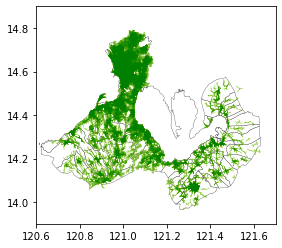

In [47]:
ax = mun_sub.plot(color='white', edgecolor='black', linewidth=0.25)
elem60.plot(ax=ax, color='yellow', alpha=0.5)
elem30.plot(ax=ax, color='green', alpha=0.5)
ax.set_xlim(120.6,121.7)
ax.set_ylim(13.9,14.9)

### Poverty Stats
#### Merging barangay shapefiles with population & poverty

In [62]:
pop = pd.read_csv('pop.csv')
pop_sub = pop.loc[(pop.adm2_name.str.contains('NCR'))|
                  (pop.adm2_name.isin(['Cavite','Laguna']))]

In [63]:
import re
def cleanName(name):
    try:
        name = re.sub('\(.*\)','',name)
        name = name.replace('City','').replace('ñ','n')
        name = re.sub(' +',' ',name)
        name = name.rstrip().lstrip()
        return(name)
    except:
        return(None)

In [64]:
pop_sub.reset_index(drop=True, inplace=True)
bgy_sub.reset_index(drop=True, inplace=True)

In [65]:
# Clean the municipality and barangay names
pop_sub['Municipality/City'] = pop_sub['Municipality/City'].apply(lambda x: cleanName(x))
bgy_sub['NAME_2'] = bgy_sub['NAME_2'].apply(lambda x: cleanName(x))


/Users/lorenzoflores/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [66]:
# Fix names for NCR
pop_sub.loc[pop_sub['Municipality/City'].isin(['Binondo','Ermita','Intramuros',
                                               'Malate','Paco','Pandacan','Port Area','Quiapo',
                                               'Sampaloc','San Miguel','San Nicolas','Santa Ana','Tondo']),
           'Municipality/City'] = 'Manila'
pop_sub.loc[pop_sub['Municipality/City']=='Caloocan','Municipality/City'] = 'Kalookan'
pop_sub.loc[pop_sub['Municipality/City']=='Gen. Mariano Alvarez',
           'Municipality/City'] = 'General Mariano Alvarez'
pop_sub = pop_sub.drop('Unnamed: 0',axis=1)


/Users/lorenzoflores/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [67]:
# Manual fix for Santa Cruz since there's both a Santa Cruz in Cavite and NCR
pop_sub.loc[(pop_sub['Municipality/City']=='Santa Cruz')&
            (pop_sub['adm1_name'].str.contains('NCR')),
           'Municipality/City'] = 'Manila'

#### Merge shapefiles to barangay using fuzzy match

In [68]:
from fuzzywuzzy import fuzz 
from fuzzywuzzy import process

In [69]:
pop_sub['adm4_name'] = pop_sub.adm4_name.apply(lambda x: cleanName(x))

In [70]:
bgy_sub['NAME_3'] = bgy_sub.NAME_3.apply(lambda x: cleanName(x))

In [71]:
def fuzzyTag(barangay, municipality, threshold):
    answer = process.extractOne(barangay, 
                           bgy_sub.loc[bgy_sub.NAME_2==municipality,'NAME_3'],
                           scorer=fuzz.token_sort_ratio)
    if answer[1]>threshold:
        return(str(bgy_sub['geometry'][answer[2]]))
    else:
        return(None) 

In [72]:
bgy_sub.reset_index(drop=True,inplace=True)
pop_sub['geometry'] = np.repeat(None,pop_sub.shape[0])


In [73]:
# String matching using Fuzzywuzzy string matching with similarity threshold of 85%
geomErr = []
for i in range(pop_sub.shape[0]):
    if i%100==0:
        print(i)
    ans = fuzzyTag(pop_sub['adm4_name'][i], 
                   pop_sub['Municipality/City'][i],
                   85)
    if ans != None:
        pop_sub.loc[i,'geometry'] = ans
    else:
        geomErr.append(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200


In [74]:
# String matching using Fuzzywuzzy string matching with lower similarity threshold of 73%
for i in geomErr:
    ans = fuzzyTag(pop_sub['adm4_name'][i], 
                   pop_sub['Municipality/City'][i],
                   73)
    if ans != None:
        pop_sub.loc[i,'geometry'] = ans
        geomErr.remove(i)

#### Aggregate on the barangay level
Initial plan was to plot poverty by barangay, but the graph would be confusing + barangays are incomplete, so we'll just aggregatem

In [75]:
pop_sub = pop_sub.reset_index(drop=True)
pop_sub['geometry_str'] = [str(item) for item in pop_sub['geometry']]
pop_sub['geometry'] = [None if item == 'None' else wkt.loads(item) for item in pop_sub['geometry_str']]
pop_sub = gpd.GeoDataFrame(pop_sub,geometry=pop_sub['geometry'])
pop_sub.to_csv('pop_sub.csv')

In [93]:
pop_sub_agg = pop_sub[['adm2_name','adm3_name','JElem_pov','SElem_pov','JHigh_pov','SHigh_pov']].groupby(['adm2_name','adm3_name']).sum()
pop_sub_agg = pop_sub_agg.reset_index()
pop_sub_agg['geometry'] = np.repeat(None,pop_sub_agg.shape[0])
for i in range(pop_sub_agg.shape[0]):
    temp = pop_sub.loc[(pop_sub.adm2_name==pop_sub_agg.adm2_name[i])&
                       (pop_sub.adm3_name==pop_sub_agg.adm3_name[i])]
    geom = gpd.GeoSeries(cascaded_union(list(filter(None,temp['geometry']))))
    pop_sub_agg.loc[i,'geometry'] = str(geom[0])

In [98]:
pop_sub_agg.to_csv('pop_sub_agg.csv')

### Plot poverty counts

In [99]:
# Turn geometries back into polygons
pop_sub_agg['geometry'] = [shapely.wkt.loads(item) for item in pop_sub_agg['geometry']]


In [100]:
pop_sub_agg = gpd.GeoDataFrame(pop_sub_agg, geometry=pop_sub_agg['geometry'])

In [101]:
pop_sub['elem_pov'] = pop_sub['JElem_pov']+pop_sub['SElem_pov']
pop_sub['high_pov'] = pop_sub['JHigh_pov']+pop_sub['SHigh_pov']

#### Number of elementary students living in poverty, colored by barangay

In [102]:
pop_sub['total_pov'] = pop_sub['elem_pov']+pop_sub['high_pov']

##### Cavite

In [164]:
cavite_agg = pop_sub[pop_sub.adm2_name=='Cavite'][['adm3_name','elem_pov','high_pov']].groupby('adm3_name').sum()

In [165]:
cavite_agg['adm3_name'] = [item.replace('City of ','') for item in list(cavite_agg.index)]

In [166]:
cavite_agg = cavite_agg.reset_index(drop=True)

In [167]:
cavite_agg.loc[cavite_agg.adm3_name=='Cavite','adm3_name'] = 'Cavite City'
cavite_agg.loc[cavite_agg.adm3_name=='Gen. Mariano Alvarez','adm3_name'] = 'General Mariano Alvarez'
cavite_agg.loc[cavite_agg.adm3_name=='Mendez (Mendez-Nuñez)','adm3_name'] = 'Mendez'
cavite_agg.loc[cavite_agg.adm3_name=='Tagaytay','adm3_name'] = 'Tagaytay City'
cavite_agg.loc[cavite_agg.adm3_name=='Trece Martires (Capital)','adm3_name'] = 'Trece Martires City'

In [168]:
mun_sub = pd.merge(mun_sub,cavite_agg,left_on='NAME_2',right_on='adm3_name',how='left')

In [169]:
sum(mun_sub[mun_sub.NAME_1=='Cavite']['elem_pov_y'])

30803.164000000008

In [170]:
sum(mun_sub[mun_sub.NAME_1=='Cavite']['high_pov_y'])

26422.07

In [172]:
mun_sub['total'] = mun_sub['elem_pov_y']+mun_sub['high_pov_y']
mun_sub[mun_sub.NAME_1=='Cavite'][['NAME_2','total']]

NAME_2     total
0                    Alfonso   622.512
1                     Amadeo   280.608
2                     Bacoor  7023.954
3                    Carmona   885.818
4                Cavite City  1728.726
5                 Dasmariñas  9927.512
6   General Emilio Aguinaldo   508.608
7    General Mariano Alvarez  3320.720
8              General Trias  3098.121
9                       Imus  4559.058
10                    Indang   856.075
11                     Kawit  1917.670
12                Magallanes  1046.276
13                Maragondon  1296.372
14                    Mendez   392.548
15                      Naic  3552.978
16                  Noveleta   895.690
17                   Rosario  1430.688
18                    Silang  4359.765
19             Tagaytay City  1059.404
20                     Tanza  5212.710
21                   Ternate   938.144
22       Trece Martires City  2311.277

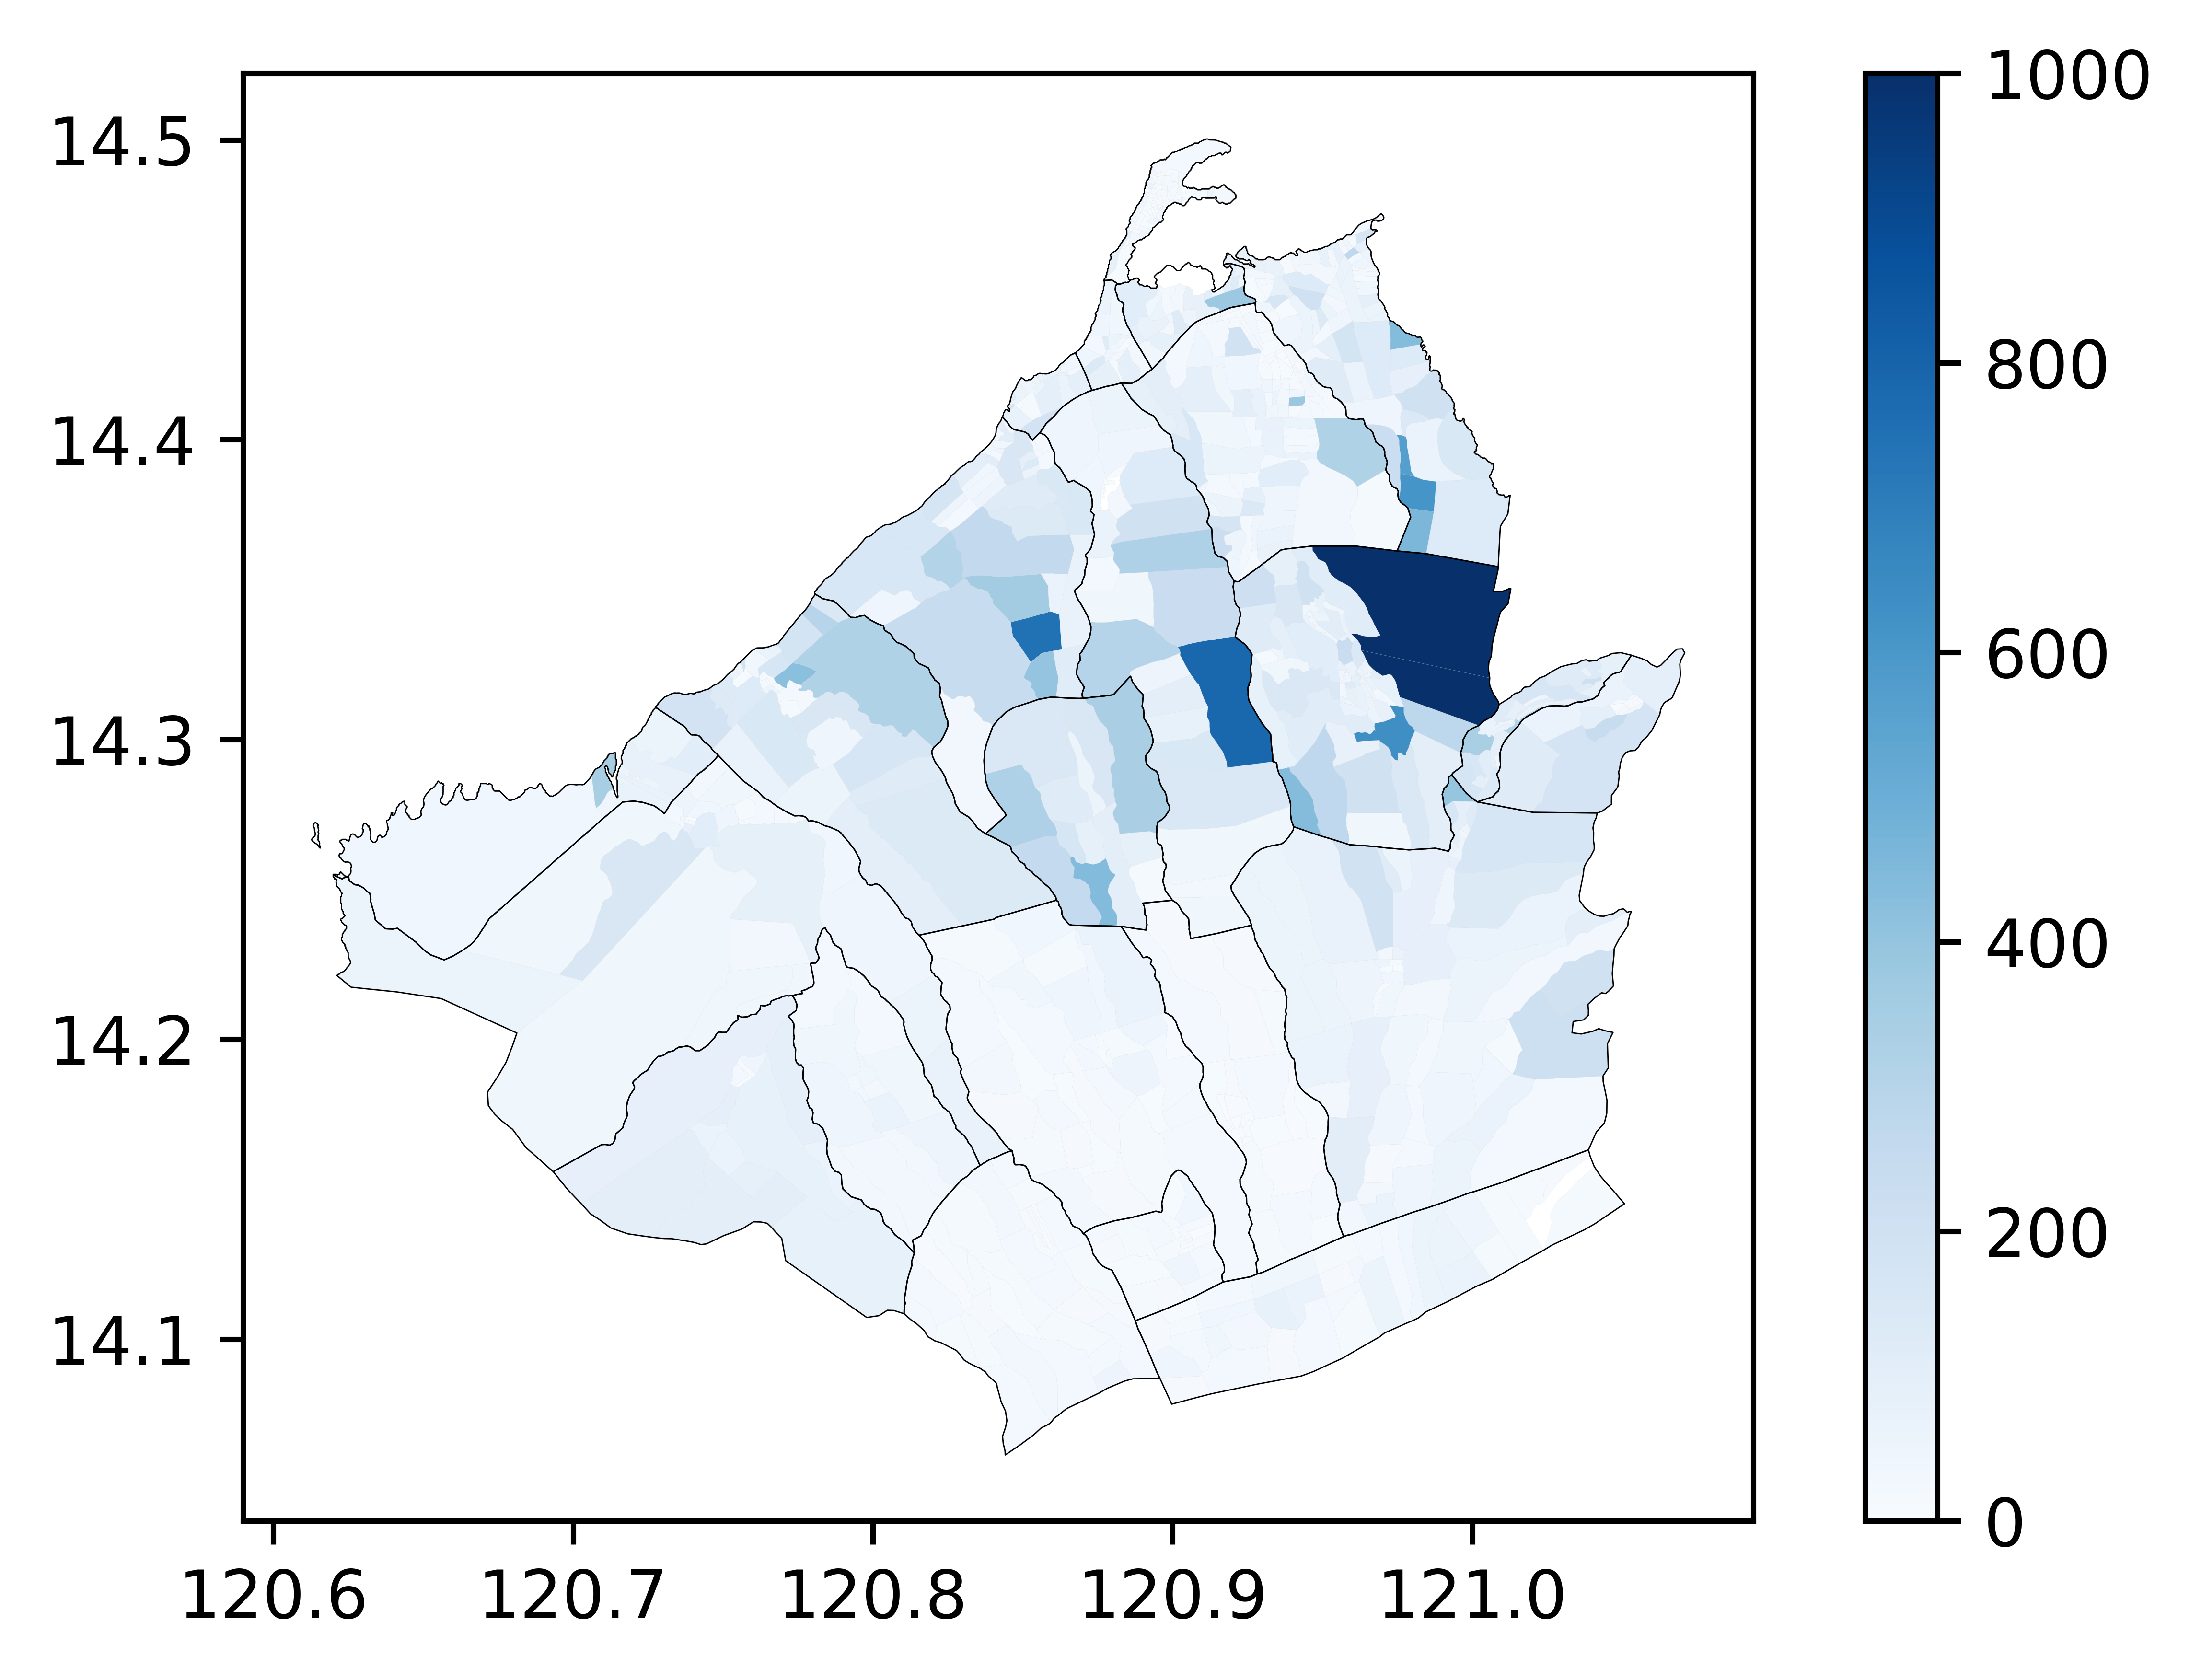

In [138]:
norm = matplotlib.colors.Normalize(0,1000,clip=True)
ax = pop_sub[pop_sub.adm2_name=='Cavite'].plot(column='total_pov', cmap='Blues', 
             linewidth=0.01, edgecolor='0.8', norm=norm, legend=True)
mun_sub[mun_sub.NAME_1=='Cavite'].plot(ax=ax, color='none', edgecolor='black', linewidth=0.2)


##### NCR

In [139]:
manila_agg = pop_sub[pop_sub.adm2_name.str.contains('NCR')][['adm3_name','elem_pov','high_pov']].groupby('adm3_name').sum()



In [140]:
manila_agg['adm3_name'] = manila_agg.index

In [141]:
manila_agg.loc[manila_agg.adm3_name.isin(['Binondo','Ermita','Intramuros','Malate',
                                              'Paco','Pandacan','Port Area','Quiapo',
                                              'Sampaloc','San Miguel','San Nicolas',
                                              'Santa Ana','Santa Cruz','Tondo I/Ii']),
              'adm3_name'] = 'Manila'

In [142]:
manila_agg = manila_agg.reset_index(drop=True)

In [143]:
manila_agg = manila_agg.groupby('adm3_name').sum()

In [144]:
manila_agg['adm3_name'] = manila_agg.index

In [145]:
manila_agg['adm3_name'] = [item.replace('City of ','') for item in manila_agg['adm3_name']]

In [146]:
manila_agg.loc[manila_agg.adm3_name=='Caloocan','adm3_name'] = 'Kalookan City'
manila_agg.loc[manila_agg.adm3_name=='Makati','adm3_name'] = 'Makati City'
manila_agg.loc[manila_agg.adm3_name=='Pasig','adm3_name'] = 'Pasig City'


In [147]:
manila_agg = manila_agg.reset_index(drop=True)

In [153]:
mun_sub = pd.merge(mun_sub.drop(['elem_pov_x','high_pov_x',
                                'elem_pov_y','high_pov_y'],axis=1),manila_agg,left_on='NAME_2',right_on='adm3_name',how='left')

In [163]:
mun_sub['total'] = mun_sub['elem_pov']+mun_sub['high_pov']
mun_sub[mun_sub.NAME_1=='Metropolitan Manila'][['NAME_2','total']]

NAME_2      total
58  Kalookan City  17641.668
59      Las Piñas   4100.745
60    Makati City   2160.851
61        Malabon   4064.535
62    Mandaluyong   1997.568
63         Manila  20603.523
64       Marikina   2839.122
65     Muntinlupa   3239.358
66        Navotas   3556.630
67      Parañaque   3922.263
68     Pasay City   2711.430
69     Pasig City   4463.675
70        Pateros    376.900
71    Quezon City  22732.644
72       San Juan    612.792
73         Taguig   5986.038
74     Valenzuela   5474.988

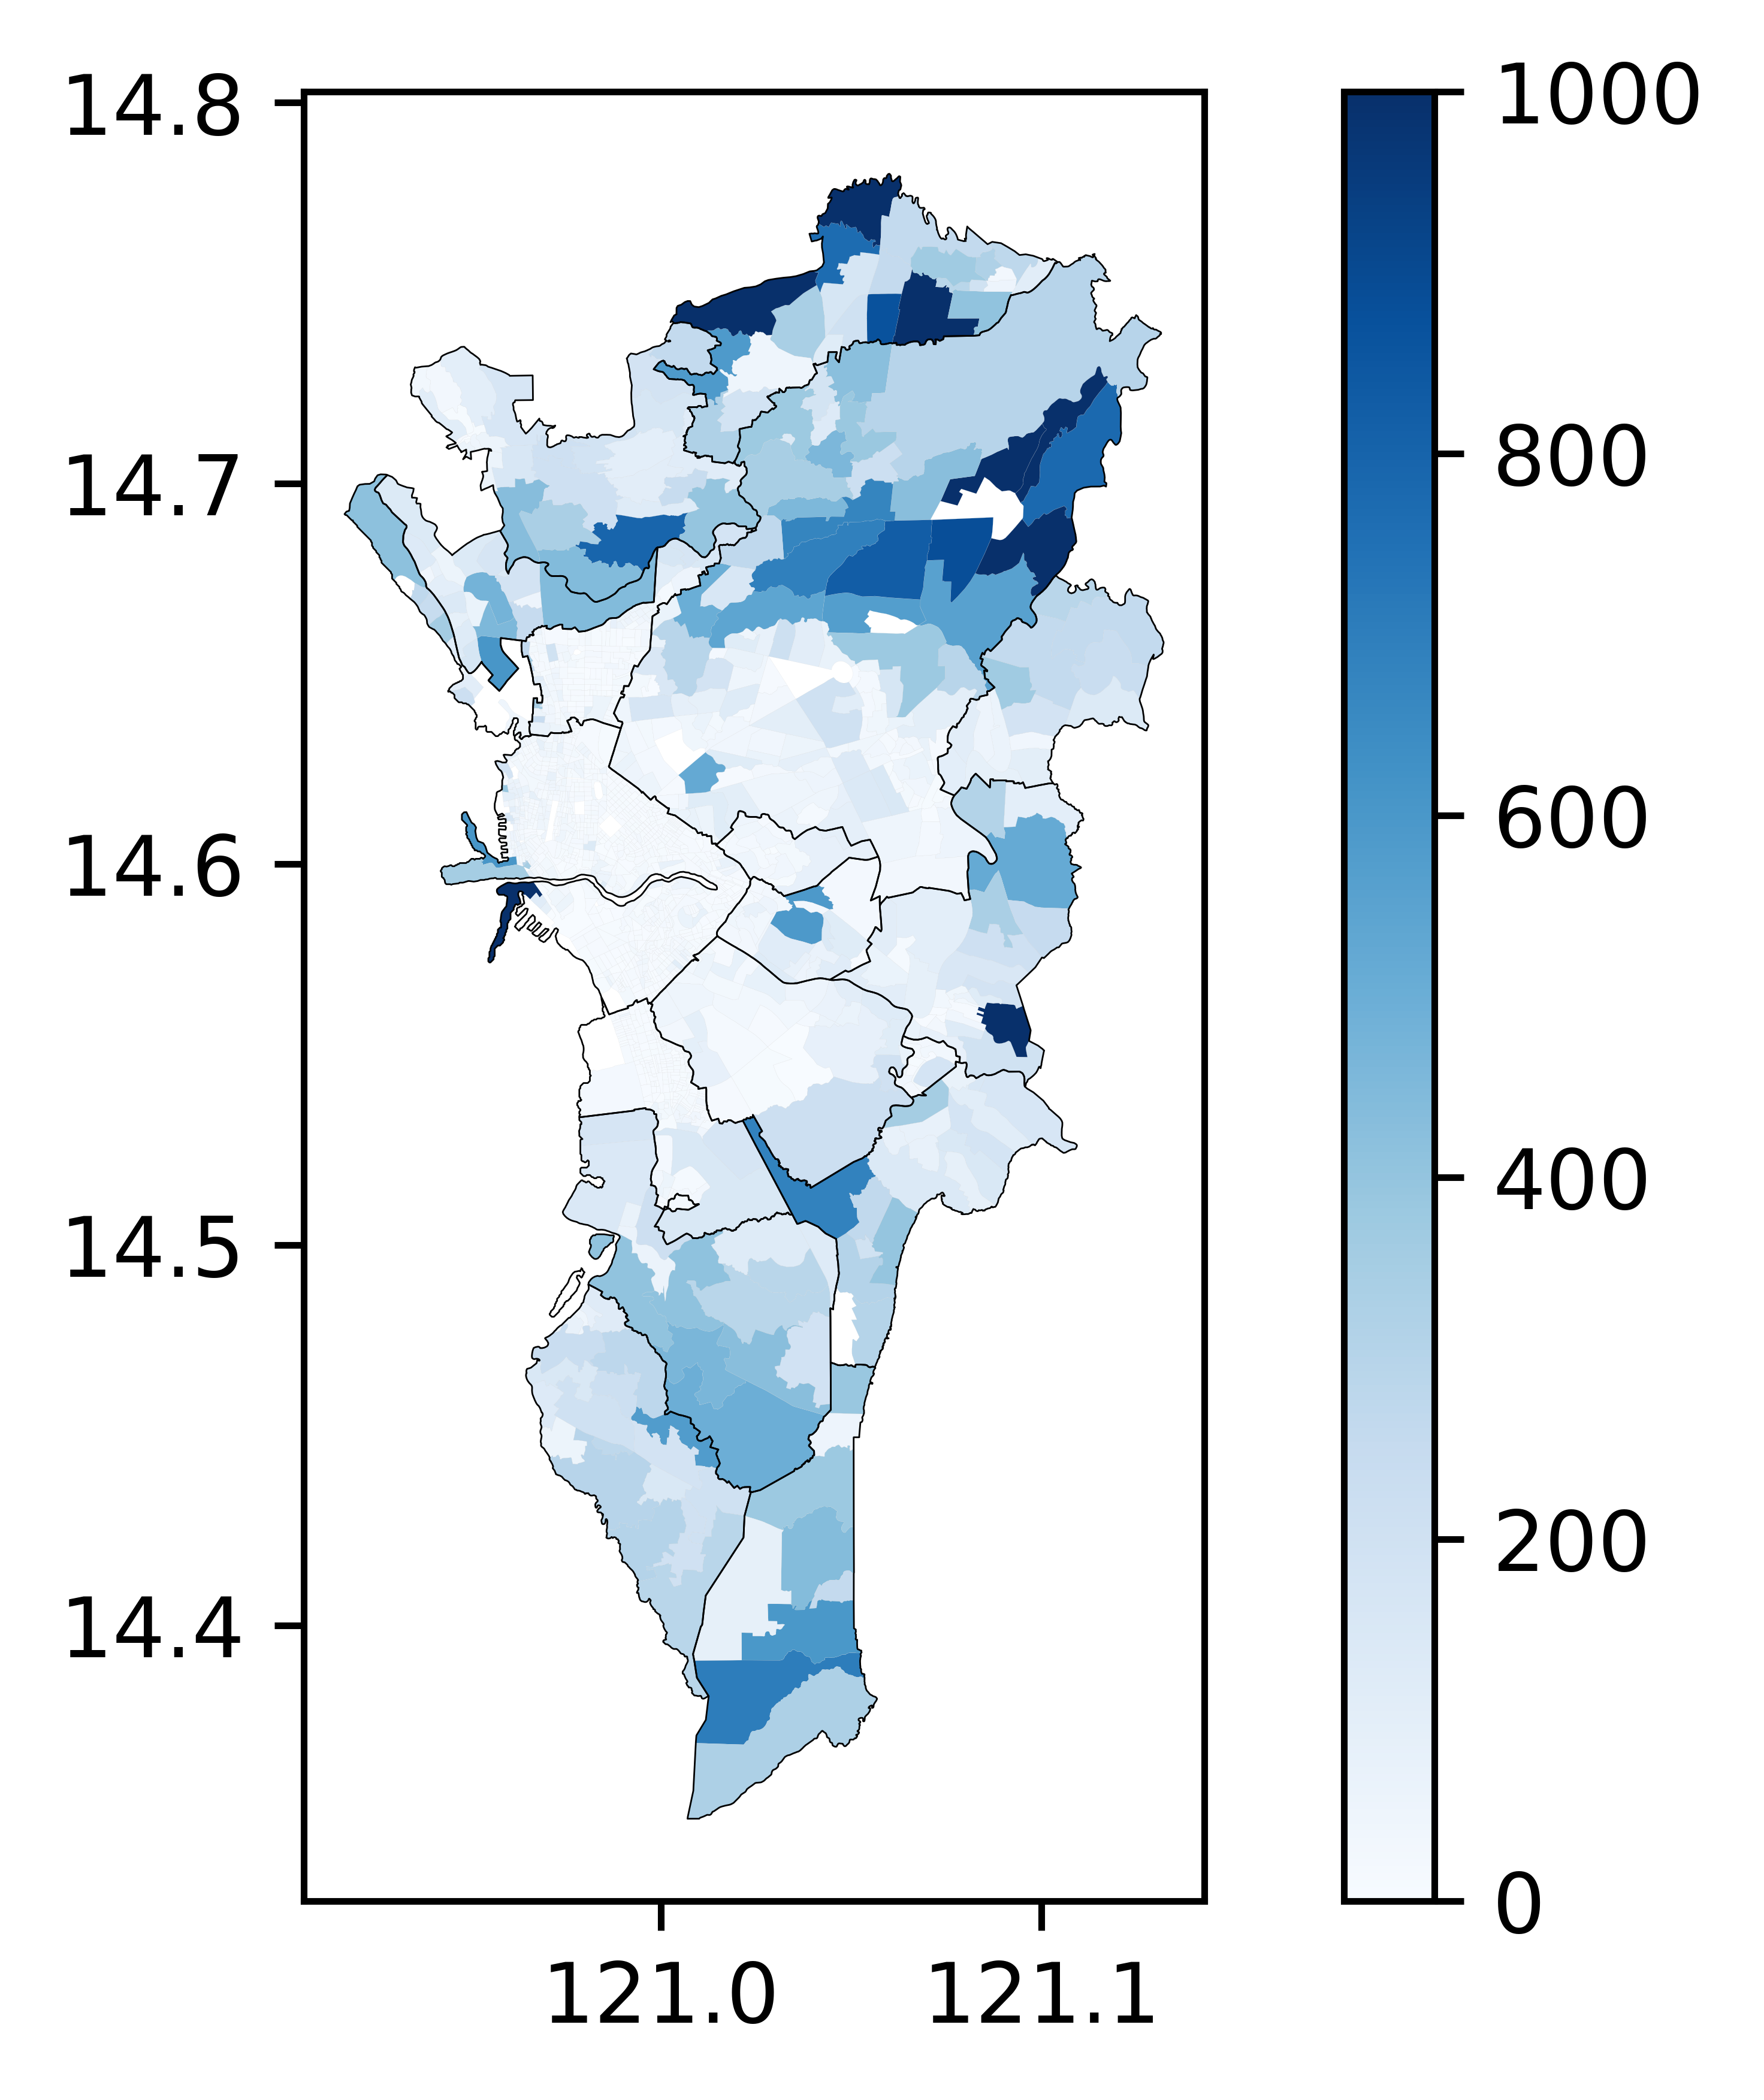

In [156]:
norm = matplotlib.colors.Normalize(0,1000,clip=True)
ax = pop_sub[pop_sub.adm2_name.str.contains('NCR')].plot(column='total_pov', cmap='Blues', 
             linewidth=0.01, edgecolor='0.8', norm=norm, legend=True)
mun_sub[mun_sub.NAME_1=='Metropolitan Manila'].plot(ax=ax, color='none', edgecolor='black', linewidth=0.2)


### Gridding HRSL data

In [4]:
hrsl = pd.read_csv('/Users/lorenzoflores/Desktop/Nerve/Online Class/PHL_youth_15_24_2019-06-01.csv')
pop = pd.read_csv('pop.csv')

In [177]:
def generatePopGrid(xmin,ymin,xmax,ymax):
    hrsl_sub = hrsl.loc[(hrsl.latitude<=ymax)&(hrsl.latitude>=ymin)&
                           (hrsl.longitude<=xmax)&(hrsl.longitude>=xmin)].reset_index(drop=True)
    hrsl_sub['geometry'] = [shapely.geometry.Point((x,y)) for (x,y) in zip(hrsl_sub.longitude,
                                                                              hrsl_sub.latitude)]
    hrsl_sub = gpd.GeoDataFrame(hrsl_sub)

    length = 0.001
    wide = 0.001

    cols = list(np.arange(xmin,xmax,wide))
    rows = list(np.arange(ymin,ymax,length))
    rows.reverse()

    polygons = []
    for x in cols:
        for y in rows:
            polygons.append(shapely.geometry.Polygon([(x,y), (x+wide, y), (x+wide, y-length), (x, y-length)]))

    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid_merged = gpd.sjoin(hrsl_sub, grid, how='left', op='intersects') 
    grid_merged = grid_merged.groupby('index_right').sum()

    grid_merged['index'] = grid_merged.index
    grid['index'] = grid.index

    grid = pd.merge(grid,grid_merged,how='left',on='index')

    grid.loc[grid.population.isnull(),'population'] = 0

    return(grid)

#### Population Grid: Laguna 

In [97]:
xmin = 121
ymin = 13.9
xmax = 121.7
ymax = 14.6
gridLaguna = generatePopGrid(xmin,ymin,xmax,ymax)
gridLaguna.to_csv('gridLaguna.csv')

#### Population Grid: Cavite

In [41]:
xmin = 120.6
ymin = 14.0
xmax = 121.1
ymax = 14.5

gridCavite = generatePopGrid(xmin,ymin,xmax,ymax)
gridCavite.to_csv('gridCavite.csv')

#### Population Grid: NCR

In [184]:
xmin = 120.9
ymin = 14.3
xmax = 121.15
ymax = 14.8

gridManila = generatePopGrid(xmin,ymin,xmax,ymax)
gridManila.to_csv('gridManila.csv')

## Plotting
#### Filter boundaries to province

In [5]:
# Labels
mun_sub['coords'] = mun_sub['geometry'].apply(lambda x: x.representative_point().coords[:])
mun_sub['coords'] = [coords[0] for coords in mun_sub['coords']]


In [27]:
# Generate municipality boundaries
from shapely.ops import cascaded_union
laguna = gpd.GeoSeries(cascaded_union(mun_sub[mun_sub.NAME_1=='Laguna']['geometry']))
cavite = gpd.GeoSeries(cascaded_union(mun_sub[mun_sub.NAME_1=='Cavite']['geometry']))
ncr = gpd.GeoSeries(cascaded_union(mun_sub[mun_sub.NAME_1=='Metropolitan Manila']['geometry']))
muns = gpd.GeoDataFrame({'name':['Laguna','Cavite','NCR'],
                         'geometry':[laguna[0],cavite[0],ncr[0]]})

In [34]:
# Subset Laguna to its boundary
gridLaguna = pd.read_csv('gridLaguna.csv')
gridLaguna['geometry'] = gridLaguna['geometry'].apply(wkt.loads)
gridLaguna = gpd.GeoDataFrame(gridLaguna, geometry=gridLaguna['geometry'])
gridLaguna = gpd.sjoin(gridLaguna, muns, how='left', op='intersects')
gridLaguna = gridLaguna[gridLaguna.name=='Laguna']

ValueError: 'left_df' should be GeoDataFrame, got <class 'pandas.core.frame.DataFrame'>

In [39]:
# Subset Cavite to its boundary
gridCavite = pd.read_csv('gridCavite.csv')
gridCavite['geometry'] = gridCavite['geometry'].apply(wkt.loads)

gridCavite = gpd.GeoDataFrame(gridCavite, geometry=gridCavite['geometry'])
gridCavite = gpd.sjoin(gridCavite[['geometry','population']], muns, how='left', op='intersects')
gridCavite = gridCavite[gridCavite.name=='Cavite']

In [40]:
# Subset Manila to its boundary
gridManila = pd.read_csv('gridManila.csv')
gridManila['geometry'] = gridManila['geometry'].apply(wkt.loads)
gridManila = gpd.GeoDataFrame(gridManila, geometry=gridManila['geometry'])

gridManila = gpd.sjoin(gridManila, muns, how='left', op='intersects')
gridManila = gridManila[gridManila.name=='NCR']

### Plotting HRSL

In [41]:
import matplotlib
old = np.seterr(invalid='ignore')


#### Plot: Laguna

In [49]:
elem30_laguna = gpd.GeoSeries(cascaded_union(elem30[elem30.province=='Laguna']['geometry']))
elem60_laguna = gpd.GeoSeries(cascaded_union(elem60[elem60.province=='Laguna']['geometry']))

AttributeError: 'Line2D' object has no property 'column'

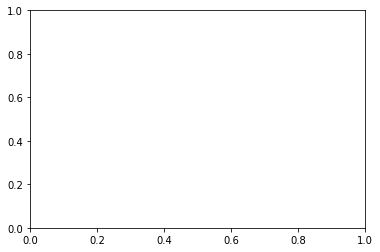

In [50]:
norm = matplotlib.colors.Normalize(0,30,clip=True)
ax = gridLaguna.plot(column='population', cmap='Blues', 
             linewidth=0.01, edgecolor='0.8', norm=norm)
elem30[elem30.province=='Laguna'].plot(ax=ax, color='yellow', alpha=1)
elem60[elem60.province=='Laguna'].plot(ax=ax, color='green', alpha=1)
mun_sub[mun_sub.NAME_1=='Laguna'].plot(ax=ax, color='none', edgecolor='black', linewidth=0.2)

ax.set_xlim(121,121.7)
ax.set_ylim(13.9,14.6)
            

#### Plot: Cavite

In [51]:
elem30_cavite = gpd.GeoSeries(cascaded_union(elem30[elem30.province=='Cavite']['geometry']))
elem60_cavite = gpd.GeoSeries(cascaded_union(elem60[elem60.province=='Cavite']['geometry']))

(14.0, 14.5)

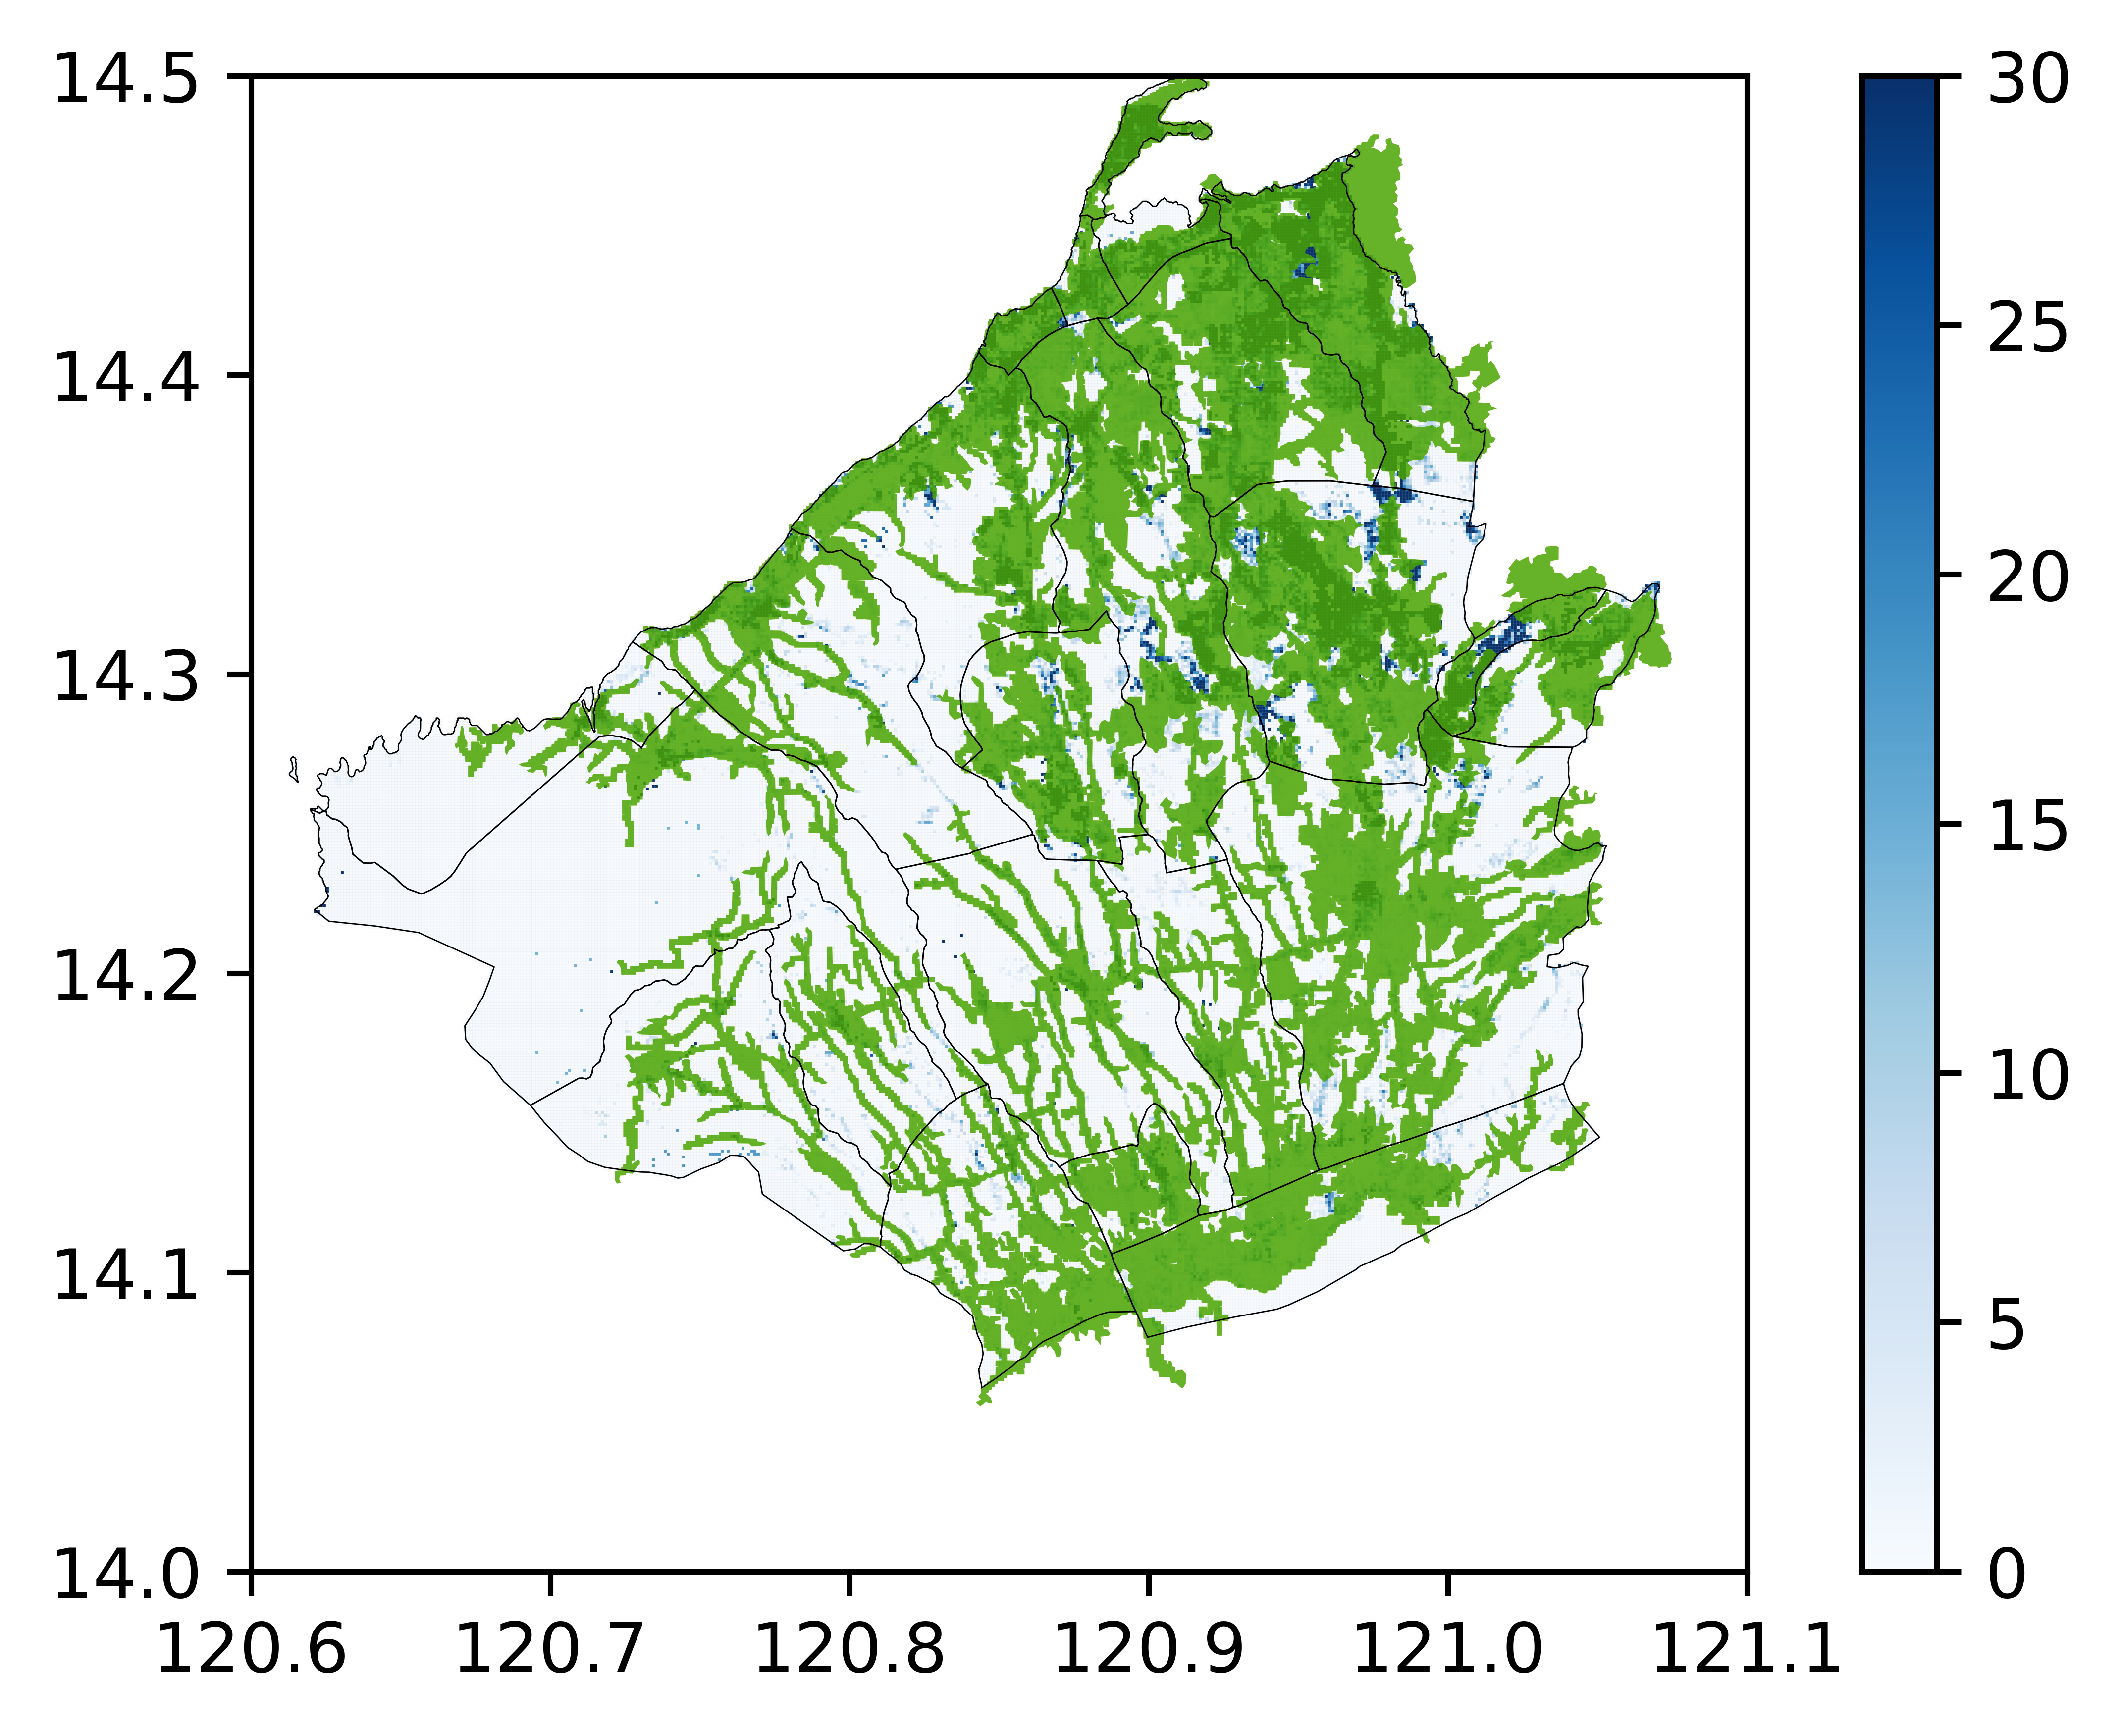

In [157]:
norm = matplotlib.colors.Normalize(0,30,clip=True)
ax = gridCavite.plot(column='population', cmap='Blues', 
             linewidth=0.01, edgecolor='0.8', norm=norm, 
                    legend=True)
elem30_cavite.plot(ax=ax, color='yellow', alpha=0.6)
elem60_cavite.plot(ax=ax, color='green', alpha=0.6)
mun_sub[mun_sub.NAME_1=='Cavite'].plot(ax=ax, color='none', edgecolor='black', linewidth=0.2, legend=True)
ax.set_xlim(120.6,121.1)
ax.set_ylim(14.0,14.5)



#### Plot: Manila

In [59]:
elem30_manila = gpd.GeoSeries(cascaded_union(elem30[elem30.province.str.contains('NCR')]['geometry']))
elem60_manila = gpd.GeoSeries(cascaded_union(elem60[elem60.province.str.contains('NCR')]['geometry']))

(14.3, 14.8)

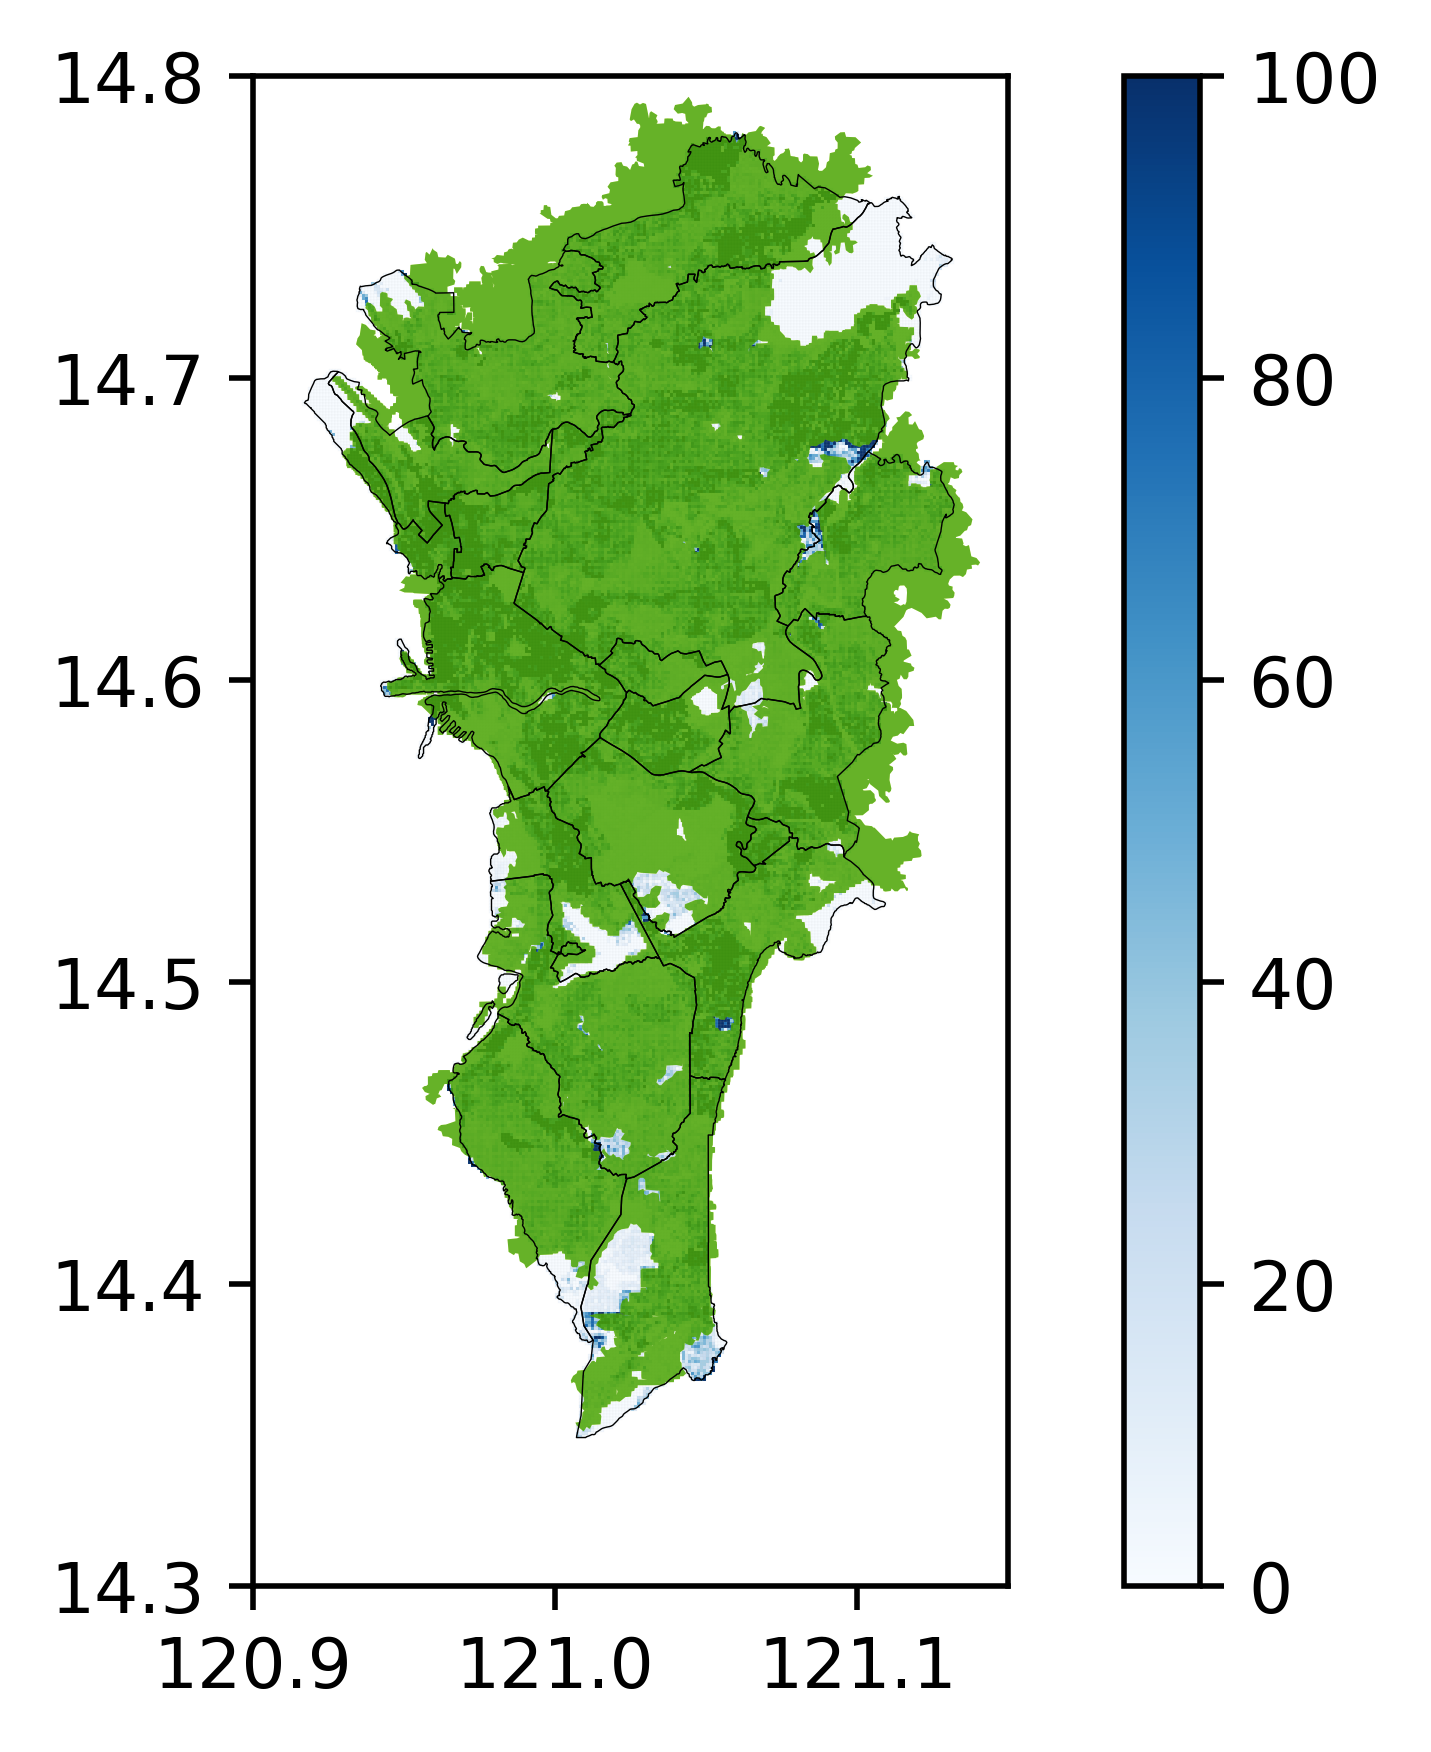

In [60]:
norm = matplotlib.colors.Normalize(0,100,clip=True)
ax = gridManila.plot(column='population', cmap='Blues', 
             linewidth=0.01, edgecolor='0.8', norm=norm, legend=True)
elem30_manila.plot(ax=ax, color='yellow', alpha=0.6)
elem60_manila.plot(ax=ax, color='green', alpha=0.6)
mun_sub[mun_sub.NAME_1=='Metropolitan Manila'].plot(ax=ax, color='none', edgecolor='black', linewidth=0.2)

ax.set_xlim(120.9,121.15)
ax.set_ylim(14.3,14.8)
